In [1]:
import os
os.chdir("..")


In [2]:
%load_ext autoreload 

In [3]:
%autoreload 2
from src.transforms.base_transform import Preprocess, CreateSynthVolume
from src.dataset.ampscz.ampscz_dataset import PretrainValAMPSCZ
import matplotlib.pyplot as plt
import torchio as tio
from torchvision.transforms import ToPILImage
from monai.transforms.intensity.array import ScaleIntensity


c:\Users\Brico\miniconda3\envs\bowl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


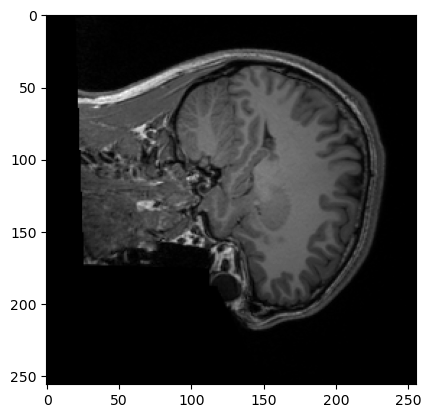

In [4]:
unp = Preprocess()({"data":r"C:\Users\Brico\Code\Master\cinamon-cookie\data-test\MR-ART\sub-000148\anat\sub-000148_acq-standard_T1w.nii.gz"})
plt.imshow(unp['data'][0,120,:,:], cmap="gray")


(tensor(1.0099), tensor(-0.2020))

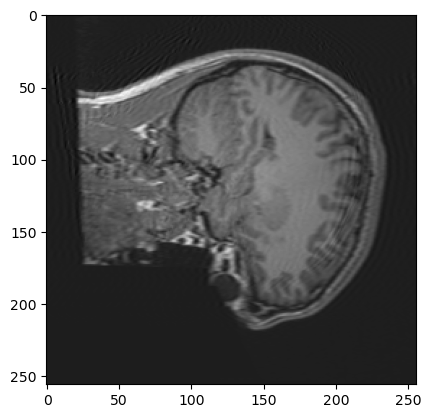

In [5]:
aug=tio.transforms.RandomMotion(degrees=[6,8],translation=[4,6])
vol = aug(unp["data"])
plt.imshow(vol[0,120,:,:], cmap="gray")
vol.max(), vol.min()

In [12]:
convert  = ToPILImage(mode="L")
converted = convert(vol[0,120,:,:])
plt.imshow(converted, cmap="gray")

ValueError: Incorrect mode (1) supplied for input type <class 'numpy.dtype'>. Should be L

(tensor(0.9394), tensor(-0.1910))

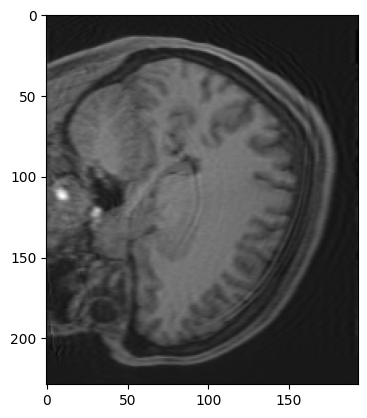

In [17]:
aug=CreateSynthVolume(elastic_activate=False)
vol =  aug(unp)["data"]
plt.imshow(vol[0,120,:,:], cmap="gray")
vol.max(), vol.min()

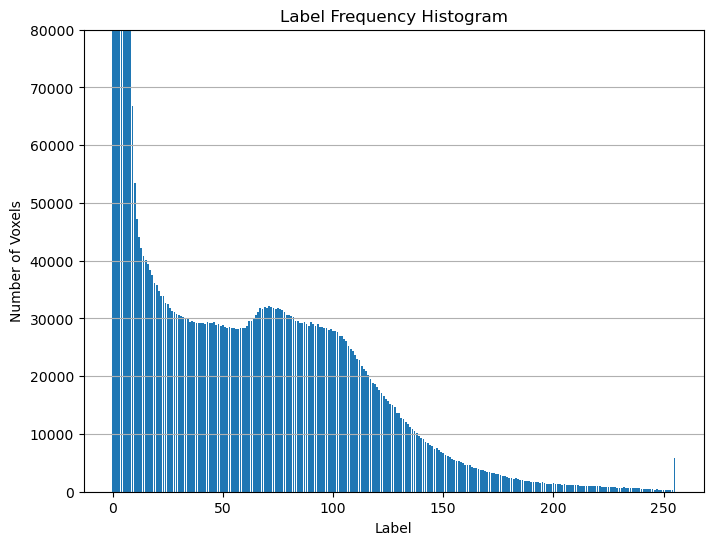

In [1]:
import os
import nibabel as nib
import matplotlib.pyplot as plt

input_label_path = 'C:/Users/Brico/Code/Master/cinamon-cookie/data-test/MRIQC/sub-HCP-YA-1200-117930/117930_3T_T1w_MPR1/mri/orig.mgz'



idx = input_label_path
def get_hist(path):
    img = nib.load(path)
    data = img.get_fdata()
    # Initialize a dictionary to store label frequencies
    label_counts = {}
    # Count the voxels for each label
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for k in range(img.shape[2]):
                label = data[i, j, k]
                if label not in label_counts:
                    label_counts[label] = 1
                else:
                    label_counts[label] += 1

    # Create the histogram
    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    plt.figure(figsize=(8, 6))
    plt.bar(labels, counts)
    plt.xlabel('Label')
    plt.ylabel('Number of Voxels')
    plt.title('Label Frequency Histogram')
    plt.grid(axis='y')

    plt.ylim(top=80000)

get_hist('C:/Users/Brico/Code/Master/cinamon-cookie/data-test/MRIQC/sub-HCP-YA-1200-117930/117930_3T_T1w_MPR1/mri/orig.mgz')


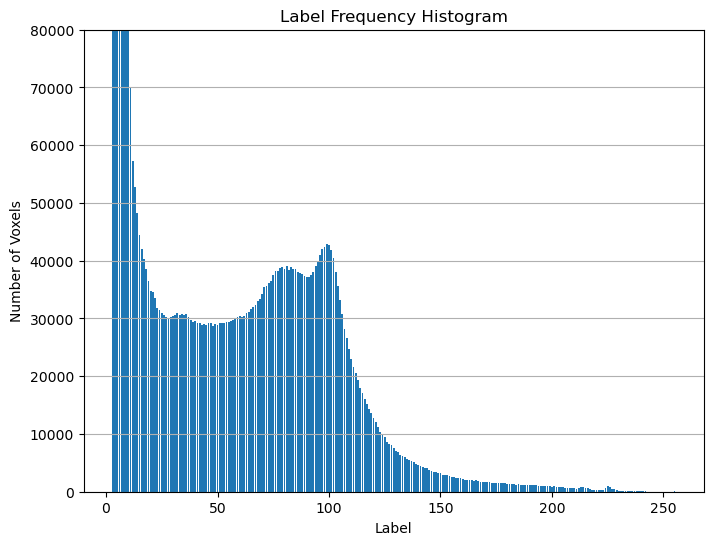

In [18]:
get_hist('C:/Users/Brico/Code/Master/cinamon-cookie/data-test/MRIQC/sub-HCP-YA-1200-117930/117930_3T_T1w_MPR1/mri/orig_nu.nii.gz')


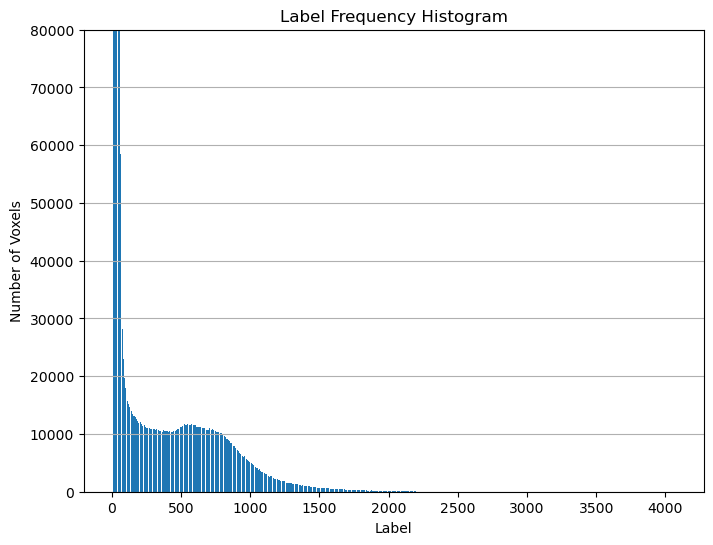

In [19]:
get_hist('C:/Users/Brico/Code/Master/cinamon-cookie/data-test/MRIQC/sub-HCP-YA-1200-117930/117930_3T_T1w_MPR1/mri/orig/001.mgz')


In [2]:
from torchio.transforms.preprocessing import ZNormalization
from monai.transforms.io.array import LoadImage

c:\Users\Brico\miniconda3\envs\bowl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


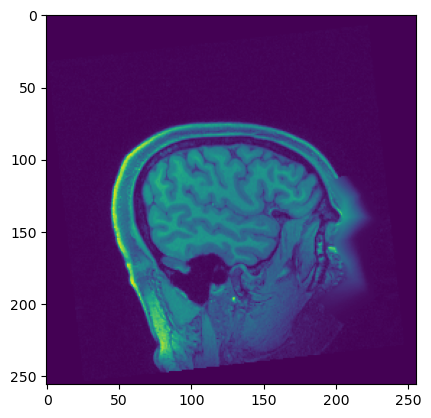

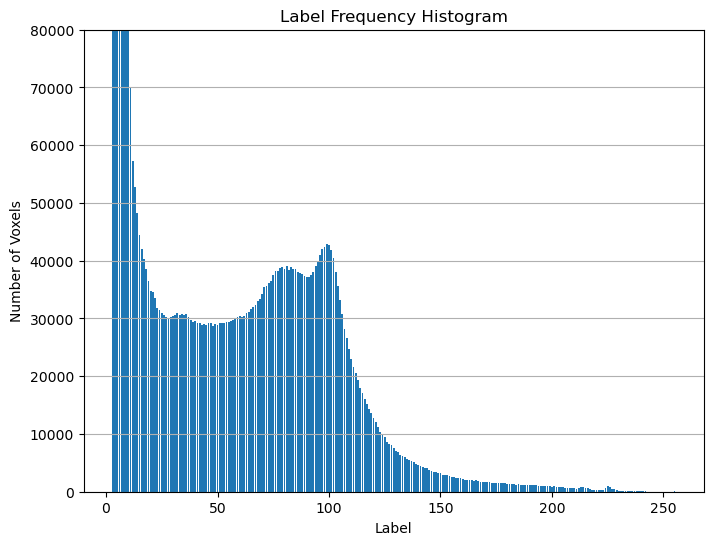

In [9]:
img = LoadImage(image_only=True, ensure_channel_first=True)('C:/Users/Brico/Code/Master/cinamon-cookie/data-test/MRIQC/sub-HCP-YA-1200-117930/117930_3T_T1w_MPR1/mri/orig_nu.nii.gz')
plt.imshow(img[0,80,:,:])
def get_hist_vol(vol):
    data = vol.numpy()
    # Initialize a dictionary to store label frequencies
    label_counts = {}
    # Count the voxels for each label
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                label = data[i, j, k]
                if label not in label_counts:
                    label_counts[label] = 1
                else:
                    label_counts[label] += 1

    # Create the histogram
    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    plt.figure(figsize=(8, 6))
    plt.bar(labels, counts)
    plt.xlabel('Label')
    plt.ylabel('Number of Voxels')
    plt.title('Label Frequency Histogram')
    plt.grid(axis='y')

    plt.ylim(top=80000)
get_hist_vol(img[0])

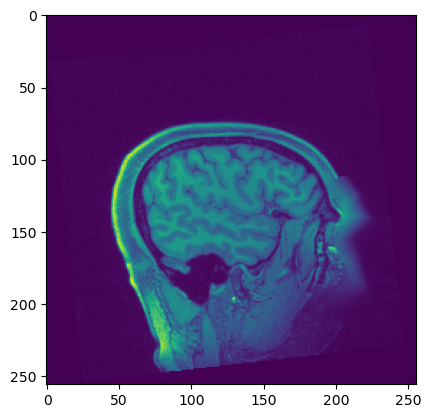

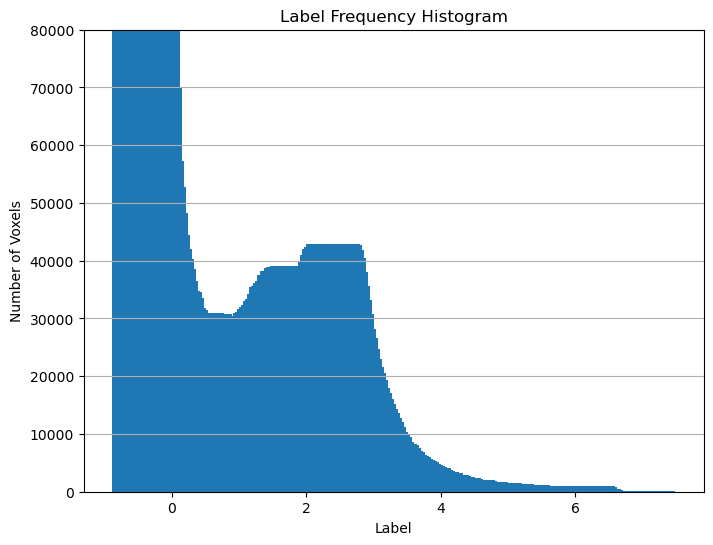

In [11]:
norm = ZNormalization()
norm_im = norm(norm_im)
plt.imshow(norm_im[0,80,:,:])
get_hist_vol(norm_im[0])